# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [21]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [22]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [23]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [24]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [25]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [26]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [27]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [28]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.Lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [29]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [30]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5246402,-77.5634729,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [31]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [35]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [36]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

911
487


Create a text index and print the Tweets containing specific keywords. 

In [37]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [38]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [39]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: University of California Health
text: 3/7  9 #COVID19 @UofCAHealth inpatients are on a ventilator. 0 COVID19 inpatients are on extracorporeal membrane ox… https://t.co/Y4UhTYN0D5
----
name: Absolut.LIBRA
text: Whoopi has #COVID19 #TheView
----
name: Cheryl Cunha
text: @mikepompeo And they don't need mandatory Covid19 vaccines.
----
name: CryDiego
text: @SethDillon @MattWalshBlog Just think of the trillions for COVID19
----
name: ████ Tech Savvy ████
text: #IYKYK #COVID19 https://t.co/TJ3eehZsBu
----
name: Oscar Cingolani, M.D.
text: #COVID19 #covidusa https://t.co/rvFeovbHqN
----
name: Marky Mark 🇺🇸
text: @ZubyMusic Ivermectin being effective as a preventative/treatment for COVID19
----
name: 757 Progressive™️🆘🦠🇺🇸🌏🔥
text: #CovidIsNotOver #COVID19 #PermanentPandemic https://t.co/cdZdSq94TT
----
name: Marcus
text: #Covid19 #GameOver #JusticePourLesSuspendus https://t.co/Pei3doY52h
----
name: CyberJedi is on Mastodon
text: Folks who have allergies to the KN95s, what are y’all u

In [40]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [41]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,63796a4b9324081b225bc040,Mon Nov 14 17:27:34 +0000 2022,1592207627312066560,1592207627312066560,3/7 9 #COVID19 @UofCAHealth inpatients are on...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.592208e+18,...,0,1,False,False,False,en,NaN,NaN,NaN,NaN
1,63796a499324081b225bbfc8,Tue Nov 15 16:02:33 +0000 2022,1592548619999399936,1592548619999399936,Whoopi has #COVID19 #TheView,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
2,63796a4f9324081b225bc103,Fri Nov 11 23:38:10 +0000 2022,1591213727281733633,1591213727281733633,@mikepompeo And they don't need mandatory Covi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.591165e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
3,63796a4d9324081b225bc088,Mon Nov 14 06:47:11 +0000 2022,1592046468420210689,1592046468420210689,@SethDillon @MattWalshBlog Just think of the t...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591993e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,63796a469324081b225bbf51,Wed Nov 16 16:48:48 +0000 2022,1592922646219395073,1592922646219395073,#IYKYK #COVID19 https://t.co/TJ3eehZsBu,False,"{'hashtags': [{'text': 'IYKYK', 'indices': [0,...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,und,"{'media': [{'id': 1592922640867532800, 'id_str...",NaN,NaN,NaN
5,63796a449324081b225bbeed,Thu Nov 17 13:14:00 +0000 2022,1593230979040423937,1593230979040423937,#COVID19 #covidusa https://t.co/rvFeovbHqN,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,7,False,False,False,und,"{'media': [{'id': 1593230975827329025, 'id_str...",NaN,NaN,NaN
6,637969de9324081b225bbdf3,Sat Nov 19 02:25:13 +0000 2022,1593792481694732289,1593792481694732289,@ZubyMusic Ivermectin being effective as a pre...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.593788e+18,...,8,75,False,False,NaN,en,NaN,NaN,NaN,NaN
7,63796a4f9324081b225bc0fc,Sat Nov 12 03:31:52 +0000 2022,1591272541523390465,1591272541523390465,#CovidIsNotOver #COVID19 #PermanentPandemic ht...,False,"{'hashtags': [{'text': 'CovidIsNotOver', 'indi...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,1,False,False,False,und,NaN,1.591272e+18,1591272011728556033,{'created_at': 'Sat Nov 12 03:29:46 +0000 2022...
8,63796a4f9324081b225bc0f7,Sat Nov 12 10:19:59 +0000 2022,1591375247038873601,1591375247038873601,#Covid19 #GameOver #JusticePourLesSuspendus ht...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,False,und,NaN,1.591364e+18,1591363938809040896,{'created_at': 'Sat Nov 12 09:35:03 +0000 2022...
9,63796a4e9324081b225bc0d2,Sun Nov 13 00:26:26 +0000 2022,1591588260454727680,1591588260454727680,"Folks who have allergies to the KN95s, what ar...",False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitt

<AxesSubplot:>

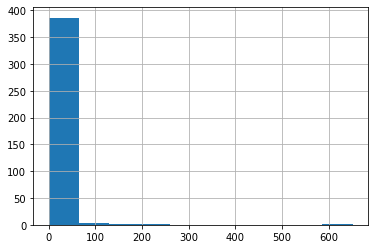

In [42]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count